In [2]:
import pyrealsense2 as rs
import numpy as np
import cv2
import torch
# import pandas
# import seaborn
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('template')
import json
from torchreid.utils import FeatureExtractor
import glob
from dataclasses import dataclass
from typing import List
import os

In [2]:
bag_file = "/home/eam/Documents/20210808_115255.bag"
keypoints_file = "/home/eam/MasterThesis/Thesis/deep-sort3d/res/alphapose-results-yolov4-rs-1.json"

In [12]:
kp_detections = open(keypoints_file, 'r')
content  = kp_detections.read()
detections = json.loads(content)
imgs = "/home/eam/MasterThesis/Thesis/deep-sort3d/notebooks/extracted_rs/frames/"
depthes = "/home/eam/MasterThesis/Thesis/deep-sort3d/notebooks/extracted_rs/depth/"

In [4]:
extractor = FeatureExtractor(
    model_name='osnet_x1_0',
    model_path='/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x1_0_imagenet.pth',
    device='cuda'
)

Successfully loaded imagenet pretrained weights from "/home/eam/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


/home/eam/anaconda3/envs/alphapose_yolo4/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
@dataclass
class ObjectModel:
    bbox : List[int]
    upper : List[int]
    features : List[float]
    lidars: List[List[float]]
        
@dataclass
class ImageModel:
    img_name:str
    objects:List[ObjectModel]

In [6]:
def get_upper_body(keypoints: List[int]):
    """
    keypoints format are liek:
    [x, y, conf, x, y, conf, ...]
    """
    # 5: right sholder
    # 6: left sholder
    # 12: left hip
    # 11: right hip
    selected_point_idx = [5,6,12,11]
    points = []
    for idx in  selected_point_idx:
        x= int(keypoints[idx*3])
        y= int(keypoints[(idx*3)+1])
        points.append([x,y])
    return np.array(points)

In [7]:
def make_upper_rect(upper_keypoint):
    if (upper_keypoint[0][0] - upper_keypoint[1][0]) < (upper_keypoint[3][0] - upper_keypoint[2][0]):
        upper_keypoint[2][0] = upper_keypoint[1][0]
        upper_keypoint[3][0] = upper_keypoint[0][0]
    else:
        upper_keypoint[1][0] = upper_keypoint[2][0]
        upper_keypoint[0][0] = upper_keypoint[3][0]
        
    
    if (upper_keypoint[3][1] - upper_keypoint[0][1]) < (upper_keypoint[2][1] - upper_keypoint[1][1]):
        upper_keypoint[2][1] = upper_keypoint[3][1]
        upper_keypoint[1][1] = upper_keypoint[0][1]
    else:
        upper_keypoint[3][1] = upper_keypoint[2][1]
        upper_keypoint[0][1] = upper_keypoint[1][1] 

In [8]:
def upper_points2bbox(upper_body):
    if upper_body[0][0] > upper_body[1][0]:
        return [upper_body[1][0], 
                upper_body[1][1], 
                abs(upper_body[1][0]-upper_body[0][0]), 
                abs(upper_body[1][1]-upper_body[2][1])]
    else:
        return [upper_body[0][0], 
                upper_body[0][1], 
                abs(upper_body[1][0]-upper_body[0][0]), 
                abs(upper_body[1][1]-upper_body[2][1])]

In [9]:
def crop(img, bboxes):
    cropped_imgs = []
    for bbox in bboxes:
        bbox = [int(round(x)) for x in bbox]
        cropped = img[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]
        cropped_imgs.append(cropped)
    return cropped_imgs

In [10]:
from itertools import groupby
grouped_detections = [list(v) for l,v in groupby(sorted(detections, key=lambda x:x["image_id"]), lambda x: x["image_id"])]

In [14]:
img_name = "01994.jpg"
img_path = os.path.join(imgs, img_name)
frame = cv2.imread(img_path)

depth_path = os.path.join(depthes, img_name.split(".")[0]+".npy")
depth_mat = np.load(depth_path)

In [18]:
frame.shape

(480, 640, 3)

In [83]:
images_info = []
cnt = 0
for detection in grouped_detections:
    if len(detection) > 0:
        img_name = detection[0]["image_id"]
        img_path = os.path.join(imgs, img_name)
        
        if not os.path.isfile(img_path):
            continue
        frame = cv2.imread(img_path)
        
        depth_path = os.path.join(depthes, img_name.split(".")[0]+".npy")
        depth_mat = np.load(depth_path)
        
        cnt+=1
        objects_info = []
        for obj in detection:
            #print(obj)
            if obj["score"] > 1.5:
                keypoints = obj["keypoints"]
                upper_body = get_upper_body(keypoints)
                make_upper_rect(upper_body)
                upper_body = [int(round(x)) for x in upper_points2bbox(upper_body)]
                bbox = [int(round(x)) for x in obj["box"]] 
                
                cropped_obj = crop(frame, [bbox])[0]
                cropped_obj = cv2.cvtColor(cropped_obj, cv2.COLOR_BGR2RGB)
                features = extractor(cropped_obj)
                
                depth_cropped = crop(depth_mat, [upper_body])[0]
                if depth_cropped.size == 0:
                    continue
                
                np_features = features.squeeze().cpu().detach().numpy().astype(float)
                obj_model = ObjectModel(bbox, upper_body, np.round(np_features,6).tolist(), np.round(depth_cropped,2).tolist())
                objects_info.append(obj_model.__dict__)
        
        img_model = ImageModel(img_name, objects_info)
        images_info.append(img_model.__dict__)

In [84]:
has_detects = [x for x in images_info if x["objects"]]

In [85]:
len(has_detects)

916

In [47]:
json_images_info = json.dumps(has_detects, indent=4,)

In [48]:
with open("dataset_final_rs_1.json", "w") as f:
    f.write(json_images_info)

In [99]:
selected_frame = has_detects[10]
selected_img_path = os.path.join(imgs, selected_frame["img_name"])
selected_img = cv2.imread(selected_img_path)
selected_img = cv2.cvtColor(selected_img, cv2.COLOR_BGR2RGB)

depth_points = selected_frame["objects"][0]["lidars"]
print(len(depth_points))

162


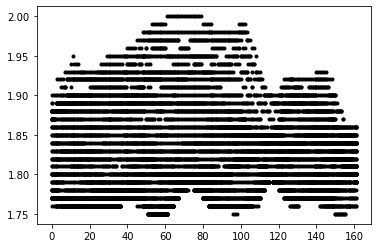

In [96]:
%matplotlib inline
plt.imshow(selected_img)
plt.show()
plt.plot(range(len(depth_points)), depth_points, '.', color='black');

[522, 74, 74, 162]
[522  74 596 236]


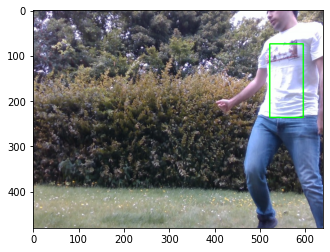

In [95]:
upper_boddy = np.array(selected_frame["objects"][0]["upper"].copy())
print(selected_frame["objects"][0]["upper"])
upper_boddy[2:4] += upper_boddy[0:2]
print(upper_boddy)
upper_bbox_img = cv2.rectangle(selected_img, upper_boddy[0:2], upper_boddy[2:4], (0,255,0), 2)
plt.imshow(upper_bbox_img)
plt.show()

In [108]:
def reject_outliers(data, m=2.0):
    """Reject outliers from distance meaurement"""
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / mdev if mdev else 0.0
    return data[s < m]


def get_depth(lidar_distances: np.ndarray, acceptable_tolerance: float) -> float:
    sub_sample = np.random.choice(lidar_distances, int(len(lidar_distances) / 4))
    depth = reject_outliers(sub_sample, acceptable_tolerance).mean()
    return depth

In [112]:
get_depth(np.array(depth_points).flatten('C'), 0.25)

CPU times: user 3.06 ms, sys: 215 µs, total: 3.27 ms
Wall time: 2.31 ms


1.8199999999999998

In [12]:
intrinsics = rs.intrinsics
intrinsics.ppx = 10
intrinsics.ppx

10

In [5]:
np.nan == np.nan

False